#Makemore

makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.


This is not meant to be too heavyweight library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. PyTorch is the only requirement.

* Bigram (one character predicts the next one with a lookup table of counts)
* MLP, following Bengio et al. 2003
* CNN, following DeepMind WaveNet 2016 (in progress...)
* RNN, following Mikolov et al. 2010
* LSTM, following Graves et al. 2014
* GRU, following Kyunghyun Cho et al. 2014
* Transformer, following Vaswani et al. 2017

####**Usage**

The included `names.txt` dataset, as an example, has the most common 32K names takes from ssa.gov for the year 2018. It looks like:
```
emma
olivia
ava
isabella
sophia
charlotte
...
```

In [119]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-17 16:24:26--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-07-17 16:24:26 (5.10 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [120]:
words=open('names.txt','r').read().splitlines()
words[:7]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [121]:
print(f" out of {len(words),} words \n the shortest is  {min(len(w) for w in words)}\n and the longest is {max(len(w) for w in words)}")

 out of (32033,) words 
 the shortest is  2
 and the longest is 15


In [122]:
#counting how common certain letter combinations are
b={}

for w in words:
  chs=['<S>']+list(w)+['<E>']
  for ch1,ch2 in zip(chs,chs[1:]):
    bigram=(ch1,ch2)
    b[bigram]=b.get(bigram,0)+1
    #print(ch1,ch2)
    #break

In [123]:
#check popularity of certain combinations
sorted(b.items(),key=lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [124]:
import torch

In [125]:
a=torch.zeros((3,5),dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [126]:
a[1,3]=1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [127]:
N=torch.zeros((28,28),dtype=torch.int32) #28 for number of letters plus <S> & <E>


In [128]:
chars=sorted(list(set(''.join(words)))) #set of all vharacters in the words file
len(chars)

26

In [129]:
stoi={s:i for i,s in enumerate(chars)}
stoi['<S>']=26
stoi['<E>']=27
stoi['j']

9

In [130]:
#counting how common certain letter combinations are
for w in words:
  chs=['<S>']+list(w)+['<E>']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    #print(ch1,ch2)
    #break

In [131]:
#itos reverse stoi dictionary
itos={i:s for s,i in stoi.items()}

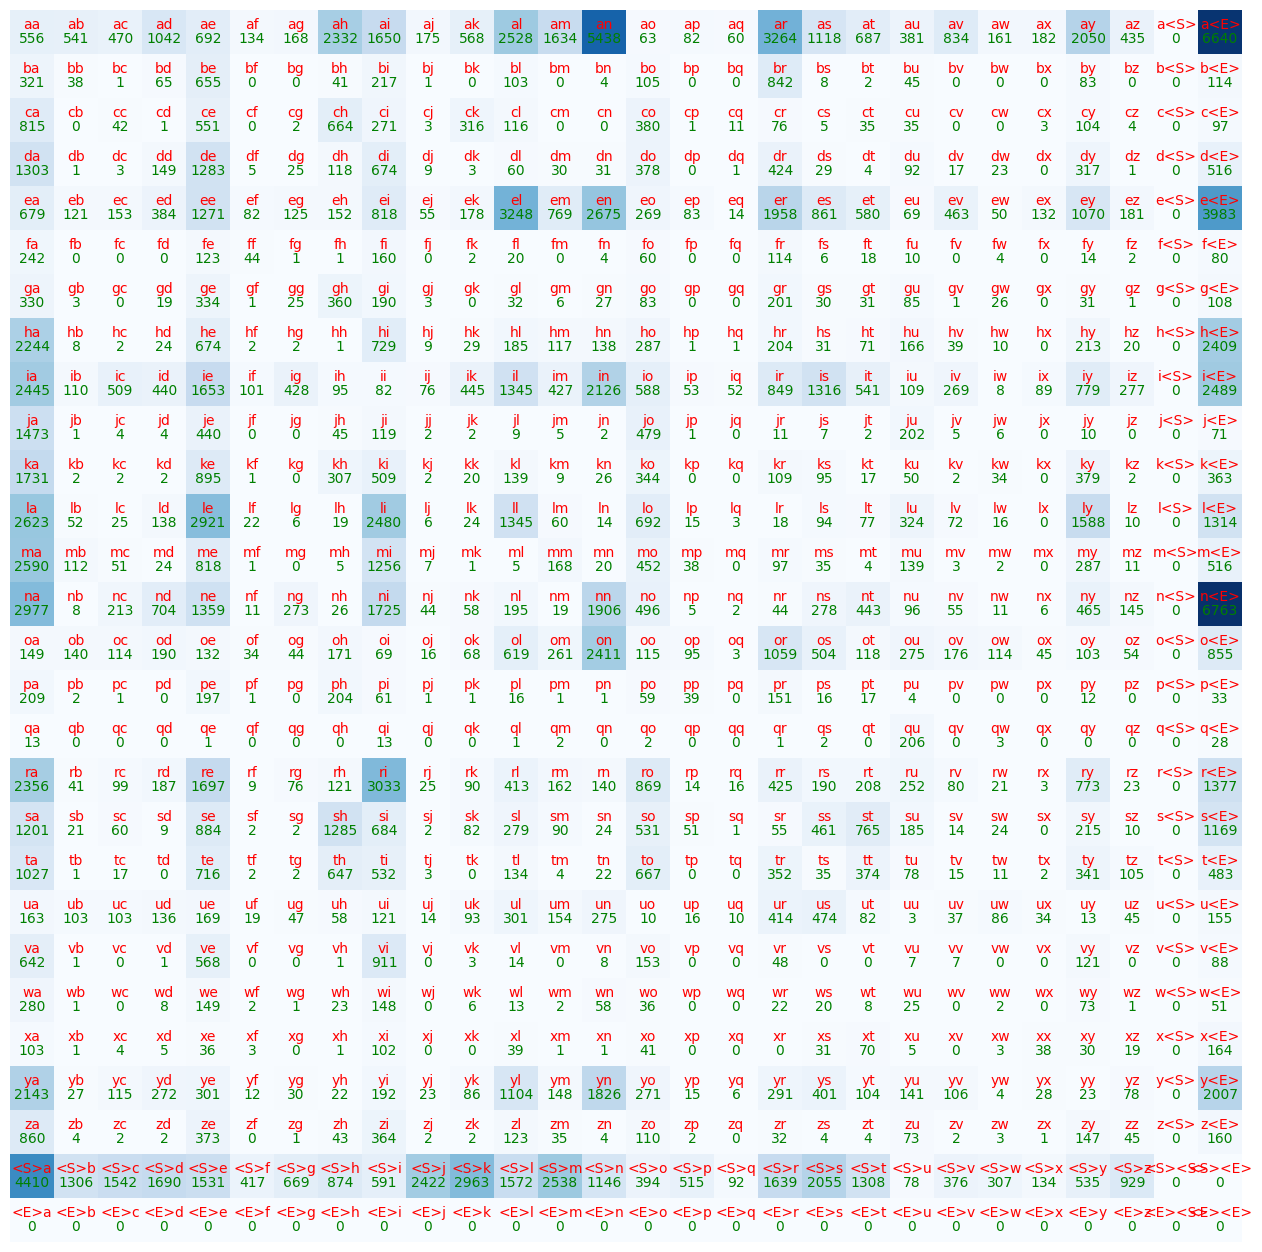

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='green')
plt.axis('off');

###change special characters

In [133]:
N=torch.zeros((27,27),dtype=torch.int32) #27 for .

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
stoi['j']

10

In [134]:
#itos reverse stoi dictionary
itos={i:s for s,i in stoi.items()}
itos[10]

'j'

In [135]:
#counting how common certain letter combinations are
for w in words:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    #print(ch1,ch2)
    #break

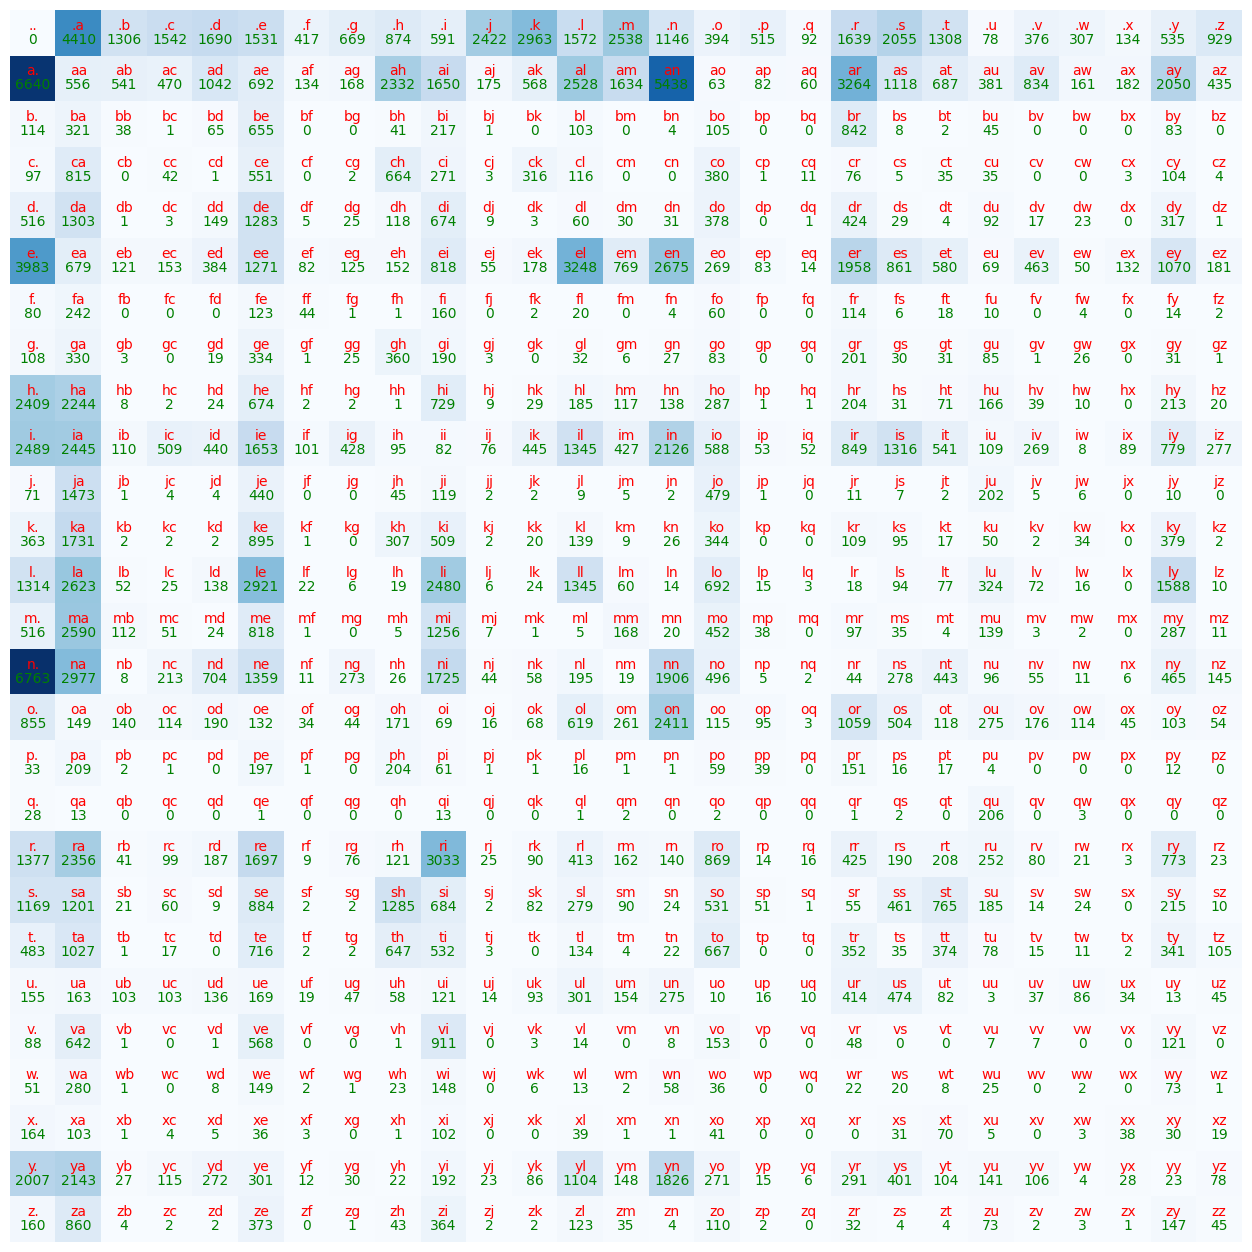

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='green')
plt.axis('off');

In [137]:
N[0,:], N[0,:].shape

(tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929], dtype=torch.int32),
 torch.Size([27]))

In [138]:
#creating a probability for first letter in names
prob=N[0].float()
p=prob/prob.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [139]:
#https://pytorch.org/docs/stable/generated/torch.Generator.html
#Creates and returns a generator object that manages the state of the algorithm which produces pseudo random numbers. Used as a keyword argument in many In-place random sampling functions.
g=torch.Generator().manual_seed(2147483647+1)
p=torch.rand(3,generator=g)
p=p/p.sum()
p

tensor([0.5070, 0.4602, 0.0327])

In [140]:
torch.multinomial(p,num_samples=20,replacement=True,generator=g)

tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [141]:
#creating a probability for first letter in names
prob=N[0].float()
p=prob/prob.sum()
g=torch.Generator().manual_seed(2147483647)
ix=torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()

ix,itos[ix]

(10, 'j')

####looping through

In [142]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
  ix=0
  out=[]

  while True:
    p=N[ix].float()
    p=p/p.sum()
    ix=torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
    #print(itos[ix],end='')
    out.append(itos[ix])
    if ix==0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [143]:
#what if model used where everything equally likely
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
  ix=0
  out=[]

  while True:
    # p=N[ix].float()
    # p=p/p.sum() comment out probability distribution
    p=torch.ones(27)/27.0
    ix=torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
    #print(itos[ix],end='')
    out.append(itos[ix])
    if ix==0:
      break
  print(''.join(out))

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.


In [144]:
P=N.float()
#0 along columns and 1 along rows
P.sum(),P.sum(0,keepdim=True),P.sum(1).shape,P.sum(1,keepdim=True).shape #keepdim for keeping row vector e.g  torch.Size([27,1]))  rather than torch.Size([27]))

(tensor(228146.),
 tensor([[32033., 33885.,  2645.,  3532.,  5496., 20423.,   905.,  1927.,  7616.,
          17701.,  2900.,  5040., 13958.,  6642., 18327.,  7934.,  1026.,   272.,
          12700.,  8106.,  5570.,  3135.,  2573.,   929.,   697.,  9776.,  2398.]]),
 torch.Size([27]),
 torch.Size([27, 1]))

In [145]:
####broadcasting semantics https://pytorch.org/docs/stable/notes/broadcasting.html
P=N.float()
P/=P.sum(1,keepdim=True) #need to divide all rows by row total and not toal sum of tensor

In [146]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
  ix=0
  out=[]

  while True:
    # p=N[ix].float()
    # p=p/p.sum() comment out probability distribution
    p=P[ix]
    ix=torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
    #print(itos[ix],end='')
    out.append(itos[ix])
    if ix==0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [147]:
for w in words[:3]:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    prob=P[ix1,ix2]
    print(f"{ch1}{ch2}: {prob:.3f}")
    #break

.e: 0.048
em: 0.038
mm: 0.025
ma: 0.390
a.: 0.196
.o: 0.012
ol: 0.078
li: 0.178
iv: 0.015
vi: 0.354
ia: 0.138
a.: 0.196
.a: 0.138
av: 0.025
va: 0.250
a.: 0.196


In [148]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [149]:

log_likelihood = 0.0
n = 0

for w in words[:3]:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    prob=P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob

    n+=1

    print(f"{ch1}{ch2}: {prob:.3f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

.e: 0.048
em: 0.038
mm: 0.025
ma: 0.390
a.: 0.196
.o: 0.012
ol: 0.078
li: 0.178
iv: 0.015
vi: 0.354
ia: 0.138
a.: 0.196
.a: 0.138
av: 0.025
va: 0.250
a.: 0.196
log_likelihood=tensor(-38.7856)
nll=tensor(38.7856)
2.424102306365967


In [150]:
log_likelihood = 0.0
n = 0

for w in ['bigmonsterstevejq']:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    prob=P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob

    n+=1

    print(f"{ch1}{ch2}: {prob:.3f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

.b: 0.041
bi: 0.082
ig: 0.024
gm: 0.003
mo: 0.068
on: 0.304
ns: 0.015
st: 0.094
te: 0.129
er: 0.096
rs: 0.015
st: 0.094
te: 0.129
ev: 0.023
ve: 0.221
ej: 0.003
jq: 0.000
q.: 0.103
log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


Since probability of `jq` of zero the log liklihood returns inf however, we want to avoid this so add 1 to N for P.

In [151]:
####broadcasting semantics https://pytorch.org/docs/stable/notes/broadcasting.html
P=(N+1).float()
P/=P.sum(1,keepdim=True) #need to divide all rows by row total and not toal sum of tensor

In [152]:
log_likelihood = 0.0
n = 0

for w in ['bigmonsterstevejq']:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    N[ix1,ix2]+=1 #add value to torch tensor for combination of letters /similar to above
    prob=P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob

    n+=1

    print(f"{ch1}{ch2}: {prob:.3f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

.b: 0.041
bi: 0.082
ig: 0.024
gm: 0.004
mo: 0.068
on: 0.303
ns: 0.015
st: 0.094
te: 0.128
er: 0.096
rs: 0.015
st: 0.094
te: 0.128
ev: 0.023
ve: 0.219
ej: 0.003
jq: 0.001
q.: 0.100
log_likelihood=tensor(-59.1267)
nll=tensor(59.1267)
3.2848143577575684


### Create training set of Bigrams

In [153]:
#create a bigram training set (x,y)
xs,ys=[],[]

for w in words[:1]:
  chs=['.']+list(w)+['.']
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1=stoi[ch1] #find index of first character
    ix2=stoi[ch2] #find index of second character
    xs.append(ix1)
    ys.append(ix2)

xs=torch.tensor(xs) #tensor([ 0,  5, 13, 13,  1])
ys=torch.tensor(ys) #tensor([ 5, 13, 13,  1,  0]) ys would be the target of x e.g 0->5, 5->13 ,etc


In [154]:
import torch.nn.functional as F
xenc=F.one_hot(xs,num_classes=27).float() #encode all five examples into vectors for above
xenc,xenc.shape

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([5, 27]))

In [155]:
W=torch.randn((27,1))
xenc @ W #torch.mm(xenc,W) #inner dimensions must match to get (5,1)

tensor([[-0.3377],
        [-1.5992],
        [ 0.8875],
        [ 0.8875],
        [ 0.8677]])

In [156]:
W=torch.randn((27,27))
xenc @ W #(5,27) @ (27,27) -> (5,27) formed by outer dimensions

tensor([[-0.1912, -1.3289,  1.3087, -0.3646, -0.0867, -0.2049,  1.5305, -2.4570,
         -0.1376, -0.2899,  0.1962,  1.6146,  0.5941, -1.2610,  0.9157,  0.0883,
         -0.7110,  0.1749,  0.2128,  0.4023,  0.0729, -0.8977, -0.2472,  0.7098,
          1.7191, -0.0365,  0.8288],
        [ 0.7574,  0.6484,  0.9077,  1.1596,  0.4439,  0.8967, -0.6062, -0.5865,
         -1.5151,  0.5531, -0.1408, -0.8836, -0.3548, -0.8398, -1.2252,  0.2825,
         -0.0936,  1.5165,  0.4225,  1.0073,  0.0128, -0.6994, -1.5716,  0.4530,
         -0.4894, -1.0420, -0.2039],
        [ 1.7620, -1.1541, -0.4846, -1.3514,  0.0265, -0.2176, -3.4162,  0.0878,
         -0.9043,  1.3037, -0.2514, -0.0196, -0.2865,  0.4133, -0.5288, -0.2967,
         -1.9868, -0.2359,  1.3397,  1.8683, -0.9033,  1.4517,  0.7921, -2.3919,
          2.1802,  1.6761, -0.7706],
        [ 1.7620, -1.1541, -0.4846, -1.3514,  0.0265, -0.2176, -3.4162,  0.0878,
         -0.9043,  1.3037, -0.2514, -0.0196, -0.2865,  0.4133, -0.5288, -0.2967

In [157]:
#exponetiate outputs (never below zero and)
#(xenc @ W).exp()
xenc=F.one_hot(xs,num_classes=27).float() #inout to the network: one-hot encoding
logits=xenc @ W #predict log-counts
counts=logits.exp() #equivalent to N
probs=counts/counts.sum(1,keepdim=True) #probabilities for next character
#btw last 2 lines here are safe as Softmax

probs,probs[0].sum() #every row sums to one as they are probabilities

(tensor([[0.0192, 0.0062, 0.0860, 0.0161, 0.0213, 0.0189, 0.1074, 0.0020, 0.0203,
          0.0174, 0.0283, 0.1168, 0.0421, 0.0066, 0.0581, 0.0254, 0.0114, 0.0277,
          0.0288, 0.0348, 0.0250, 0.0095, 0.0182, 0.0473, 0.1297, 0.0224, 0.0532],
         [0.0599, 0.0537, 0.0696, 0.0895, 0.0438, 0.0688, 0.0153, 0.0156, 0.0062,
          0.0488, 0.0244, 0.0116, 0.0197, 0.0121, 0.0082, 0.0372, 0.0256, 0.1279,
          0.0428, 0.0769, 0.0284, 0.0139, 0.0058, 0.0442, 0.0172, 0.0099, 0.0229],
         [0.1114, 0.0060, 0.0118, 0.0050, 0.0196, 0.0154, 0.0006, 0.0209, 0.0077,
          0.0705, 0.0149, 0.0188, 0.0144, 0.0289, 0.0113, 0.0142, 0.0026, 0.0151,
          0.0730, 0.1239, 0.0078, 0.0817, 0.0422, 0.0017, 0.1693, 0.1023, 0.0089],
         [0.1114, 0.0060, 0.0118, 0.0050, 0.0196, 0.0154, 0.0006, 0.0209, 0.0077,
          0.0705, 0.0149, 0.0188, 0.0144, 0.0289, 0.0113, 0.0142, 0.0026, 0.0151,
          0.0730, 0.1239, 0.0078, 0.0817, 0.0422, 0.0017, 0.1693, 0.1023, 0.0089],
         [0.

In [158]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0192, 0.0062, 0.0860, 0.0161, 0.0213, 0.0189, 0.1074, 0.0020, 0.0203,
        0.0174, 0.0283, 0.1168, 0.0421, 0.0066, 0.0581, 0.0254, 0.0114, 0.0277,
        0.0288, 0.0348, 0.0250, 0.0095, 0.0182, 0.0473, 0.1297, 0.0224, 0.0532])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.018938783556222916
log likelihood: -3.966543436050415
negative log likelihood: 3.966543436050415
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0599, 0.0537, 0.0696, 0.0895, 0.0438, 0.0688, 0.0153, 0.0156, 0.0062,
        0.0488, 0.0244, 0.0116, 0.0197, 0.0121, 0.0082, 0.0372, 0.0256, 0.1279,
        0.0428, 0.0769, 0.0284, 0.0139, 0.0058, 0.0442, 0.0172, 0.0099, 0.0229])
label (actual next character): 13
probability assigned by the net to the the correct character: 0

####--------Optimization-------

In [159]:
xs

tensor([ 0,  5, 13, 13,  1])

In [160]:
ys

tensor([ 5, 13, 13,  1,  0])

In [161]:
probs[0,5],probs[1,13],probs[2,13],probs[3,1],probs[4,0] #looking for probabilities for next likely

(tensor(0.0189),
 tensor(0.0121),
 tensor(0.0289),
 tensor(0.0060),
 tensor(0.0323))

In [162]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [163]:
[torch.arange(5),ys]

[tensor([0, 1, 2, 3, 4]), tensor([ 5, 13, 13,  1,  0])]

In [164]:
probs[torch.arange(5), ys]

tensor([0.0189, 0.0121, 0.0289, 0.0060, 0.0323])

In [165]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [166]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [167]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [168]:
W.data += -0.1 * W.grad

###Optimization but really though

In [169]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [173]:
# gradient descent
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

2.4938690662384033
2.491464376449585
2.489628314971924
2.488198757171631
2.4870662689208984
2.4861562252044678
2.485414743423462
2.4848034381866455
2.4842944145202637
2.483865261077881


In [174]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
prelay.
a.
nn.
